In [1]:
import skimage.measure as msr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd

import glob
import os
from pathlib import Path
import imageio
import cv2

# Importing class from wmark.py
from wmark import WaterMark

In [36]:
# Source Directory
src_folder = 'TestSet/'
# Source Path
src_pth = Path(src_folder).resolve()

# Destination Directory
dst_folder = Path(src_folder+'/marked/').resolve()
# Creating folder for marked images
Path(dst_folder).mkdir(exist_ok=True)
# Destination Path
dst_path = Path(dst_folder).resolve()

8057


/Users/zgebac/anaconda3/envs/conda-env_python/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


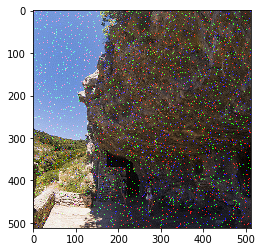

In [37]:
# Creating empty DataFrames that will fill up during the loop
big_corr = pd.DataFrame()

for i in range(1, 2):
    
    # Generating random seed as integer up to 10000
    random_nums = np.random.randint(10000, size=(1))
    random_num = random_nums[0]
    print(random_num)

    w_object = WaterMark(random_num)

    # All TIF files in the src_path are now imgs
    imgs_source = src_pth.glob('*.tif')
    
    # Creating empty DataFrames that will fill up during the loop
    final_corr_original = pd.DataFrame()
    
    # Creating empty DataFrames that will fill up during the loop
    final_corr_marked = pd.DataFrame()
    
    # Counting the number of images in src_folder
    list = os.listdir(src_folder)
    # Counting folder as two files?!
    num_images = len(list) - 2
    
    results = np.zeros([num_images, 8])
    counter = 0
        

    for img in imgs_source:
    
        # Read original image
        img_original = WaterMark.imread(img)
        
        # Find impact factor within a PSNR range
        find_impact_factor = w_object.findImpactFactor(img_original, rangePSNR = (35,40))
        
        # Mark image
        img_marked = w_object.embedMark(img_original, factor = find_impact_factor)
        # img_name_io = f"{str(dst_folder)}/marked-{random_num}-{str(img.name)}"
        # imageio.imwrite(img_name_io, img_to_dst)
        
        
        #SCALING
        #SCALING
        #SCALING
        
        # Wanted value of scaled image (in pixels)
        height = 768
        width = 768
        # Scaling
        img_scaled = cv2.resize(img_marked, (width, height))

        
        #ROTATION
        #ROTATION
        #ROTATION
        
        angle = 90
        rows, cols = img_marked.shape[:2]
        # Defines center if image and angle of rotation
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        # Defines result image
        img_rotated = cv2.warpAffine(img_marked, M, (cols, rows))    

        
        
        # AFFINE TRANSFORMATION
        # AFFINE TRANSFORMATION
        # AFFINE TRANSFORMATION
        
        # Defining points in original image
        point_1_a = [50, 50]
        point_1_b = [200, 50]
        point_1_c = [50, 200]
        # Defining points in transformed image
        point_2_a = [10, 100]
        point_2_b = [200, 50]
        point_2_c = [100, 250]
        
        rows, cols, ch = img_marked.shape
        # Compiling original points into single array
        pts1 = np.float32([point_1_a, point_1_b, point_1_c])
        # Compiling transformed points into single array
        pts2 = np.float32([point_2_a, point_2_b, point_2_c])
        M = cv2.getAffineTransform(pts1, pts2)
        img_affined = cv2.warpAffine(img_marked, M, (cols, rows))
       
        
        # 2D CONVOLUTION
        # 2D CONVOLUTION
        # 2D CONVOLUTION
        
        # Horizontal deviation (intensity)
        kernel_x = 3
        # Vertical deviation (intensity)
        kernel_y = 3
        kernel_x_str = str(kernel_x)
        kernel_y_str = str(kernel_y)
        kernel_multiplication = kernel_x * kernel_y
        
        kernel = np.ones((kernel_x, kernel_y), np.float32)/kernel_multiplication
        img_convoluted = cv2.filter2D(img_marked, -1, kernel)
       
        
        # GAUSSIAN BLUR
        # GAUSSIAN BLUR
        # GAUSSIAN BLUR
        
        # Horizontal deviation (blur intensity)
        kernel_x = 3
        # Vertical deviation (blur intensity)
        kernel_y = 3
        kernel_x_str = str(kernel_x)
        kernel_y_str = str(kernel_y)
        
        img_blurred = cv2.GaussianBlur(img_marked, (kernel_x, kernel_y), cv2.BORDER_DEFAULT)
  
        
        # GAUSSIAN NOISE
        # GAUSSIAN NOISE
        # GAUSSIAN NOISE
        
        # Wanted value of rotation angle (in degrees)
        noise_amount = 0.5
        
        # Generate Gaussian noise
        gauss = np.random.normal(0, noise_amount, img_marked.size)
        gauss = gauss.reshape(
            img_marked.shape[0], img_marked.shape[1], img_marked.shape[2]).astype('uint8')
        # Add the Gaussian noise to the image
        img_noised = cv2.add(img_marked, gauss)
      
        
        corr_original = w_object.decodeMark(img_original)
        results[counter, 0] = corr_original
        
        corr_marked = w_object.decodeMark(img_marked)
        results[counter, 1] = corr_marked
        
        corr_scaled = w_object.decodeMark(img_scaled)
        results[counter, 2] = corr_scaled
        
        corr_rotated = w_object.decodeMark(img_rotated)
        results[counter, 3] = corr_rotated
        
        corr_affined = w_object.decodeMark(img_affined)
        results[counter, 4] = corr_affined
        
        corr_convoluted = w_object.decodeMark(img_convoluted)
        results[counter, 5] = corr_convoluted
        
        corr_blurred = w_object.decodeMark(img_blurred)
        results[counter, 6] = corr_blurred
        
        corr_noised = w_object.decodeMark(img_noised)
        results[counter, 7] = corr_noised
        
        counter += 1
        
        
        pandas_values = ["Original", "Marked", "Scaled", "Rotated", "Affined", "2D Convoluted", "Blurred", "Noised"]
        pandas_seeds = [f"{random_num}", f"{random_num}", f"{random_num}", f"{random_num}", f"{random_num}", f"{random_num}", f"{random_num}", f"{random_num}"]
        
        final_corr = pd.DataFrame(results, columns = [pandas_seeds, pandas_values])
    

    big_corr = pd.concat([big_corr, final_corr], axis = 1)

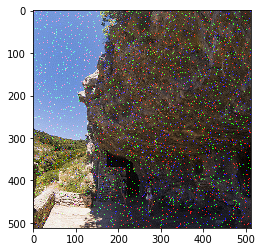

In [50]:
plt.imshow(img_noised)

In [45]:
# Show Pandas DataFrame
big_corr

8057                                                                 \
     Original       Marked      Scaled     Rotated     Affined 2D Convoluted   
0  -86.649081  3718.198198   31.057671  224.140239   81.432715   1362.565436   
1  546.391311  4278.756237  752.288636  544.645754  180.538062   1584.716032   
2  222.880806  7630.468309  230.628554  268.789261  -45.029723   2799.245961   
3   69.155811  2645.170856  140.775910   77.844086  -66.658347    993.027877   
4   77.442216  6930.385504  140.130425  318.735115   20.672880   2500.259538   

                             
       Blurred       Noised  
0  1374.965206  2826.495030  
1  1598.345879  3707.956671  
2  2823.917689  6086.108333  
3  1002.006803  1927.090515  
4  2533.294382  5621.659617

In [ ]:
stacked_dataframe = big_corr.stack(0)

In [ ]:
stacked_dataframe

In [17]:
big_corr.describe()

57                                                   \
         Original       Marked      Scaled     Rotated     Affined   
count    5.000000     5.000000    5.000000    5.000000    5.000000   
mean   246.538781  2468.780546  176.113156  118.750951  209.832924   
std    196.094186  1072.335646  120.579200   66.930972  145.042235   
min    107.529773  1184.497425   75.898078   23.663625   75.204701   
25%    131.823480  1843.277097  111.634349  104.573755  121.056907   
50%    140.299402  2354.106132  150.453705  111.128247  138.560170   
75%    276.096426  2982.710985  159.082000  147.303010  287.723637   
max    576.944825  3979.311093  383.497649  207.086118  426.619205   

                                              
      2D Convoluted     Blurred       Noised  
count      5.000000    5.000000     5.000000  
mean     268.227343  222.497800  1647.663869  
std       82.827317   63.227386   685.180946  
min      189.700872  164.481064   845.163976  
25%      216.474160  177.674994  1081.153231  
50%      222.477231  191.585508  1751.994006  
75%      333.766158  270.460263  2053.775963  
max      378.718292  308.287169  2506.232167

In [ ]:
plt.style.use('fivethirtyeight')

stacked_dataframe.plot(kind = 'bar', stacked = False, legend = True)
plt.show()

In [ ]:
stacked_dataframe.plot.hist(legend = True)